In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


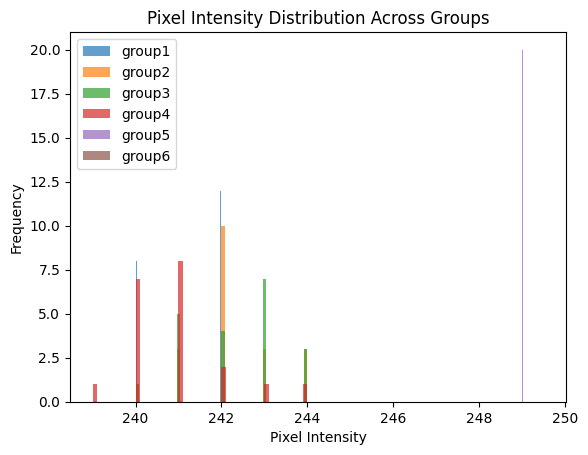

{'group1': {'max_intensity': 242, 'min_intensity': 240}, 'group2': {'max_intensity': 244, 'min_intensity': 240}, 'group3': {'max_intensity': 244, 'min_intensity': 240}, 'group4': {'max_intensity': 244, 'min_intensity': 239}, 'group5': {'max_intensity': 249, 'min_intensity': 249}, 'group6': {'max_intensity': 242, 'min_intensity': 241}}


In [100]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

dataset_path = r"D:\DIP project\datset\IR_flame_dataset\IR_dataset\train_set"

group_stats = {}

for group in os.listdir(dataset_path):
    group_path = os.path.join(dataset_path, group)
    if os.path.isdir(group_path):
        intensities = []
        for img_name in os.listdir(group_path):
            img_path = os.path.join(group_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                intensities.append(np.max(img))  # Maximum intensity in the image
        group_stats[group] = {"max_intensity": np.max(intensities), "min_intensity": np.min(intensities)}
        plt.hist(intensities, bins=50, alpha=0.7, label=group)

plt.title("Pixel Intensity Distribution Across Groups")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(group_stats)


In [101]:
import os
import cv2
import numpy as np

# Define thresholds
def assign_label_by_intensity(image, threshold=244):
    max_intensity = np.max(image)
    #print("max",max_intensity)
    if max_intensity <= threshold:
        return 0
    else:
        return 1  # Moderate Temperature

# Re-label images
dataset_path = r"D:\DIP project\datset\IR_flame_dataset\IR_dataset\train_set"



In [102]:
def load_images(data_dir):
    images = []
    labels = []
    for group in os.listdir(dataset_path):
        group_path = os.path.join(dataset_path, group)
        if os.path.isdir(group_path):
            for img_name in os.listdir(group_path):
                img_path = os.path.join(group_path, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    labels.append(assign_label_by_intensity(image))
                    image = cv2.resize(image, (128, 128)) 
                    images.append(image)
                else: 
                    print("failed")             
                
    return np.array(images), np.array(labels)

In [103]:
original_train_images, train_labels = load_images(dataset_path)


In [104]:

unique, counts = np.unique(train_labels, return_counts=True)
print(f"Class Distribution: {dict(zip(unique, counts))}")

Class Distribution: {0: 100, 1: 20}


In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import cv2

# Initialize augmentation generator
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)

augmented_images = []
augmented_labels = []

# Target number of samples per class (equal to the max class size before augmentation)
target_class_size = max(Counter(train_labels).values())

# Perform augmentation for all classes
for img, label in zip(original_train_images, train_labels):
    
    # Ensure the image has the shape (128, 128, 1)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (128, 128, 1)
    img = np.expand_dims(img, axis=0)   # Add batch dimension (1, 128, 128, 1)

    # Count current number of images in the class
    current_class_count = np.count_nonzero(train_labels == label)
 
    # If the current class has fewer images than the target size, augment
    if current_class_count < target_class_size:
        augment_count = target_class_size - current_class_count
        for _ in range(augment_count):
            augmented_img = datagen.flow(img, batch_size=1).next()[0].astype('uint8')
            augmented_images.append(augmented_img)  # Augmented image has shape (128, 128, 1)
            augmented_labels.append(label)
    else:
        augment_count = 14
        for _ in range(augment_count):
            augmented_img = datagen.flow(img, batch_size=1).next()[0].astype('uint8')
            augmented_images.append(augmented_img)  # Augmented image has shape (128, 128, 1)
            augmented_labels.append(label)

# Combine original and augmented data




# Ensure augmented images are in the correct shape (128, 128, 1)
augmented_images = np.array(augmented_images)

augmented_images = np.squeeze(augmented_images, axis=-1)
augmented_labels = np.array(augmented_labels)


# Check shapes before concatenation
print(f"Original images shape: {original_train_images.shape}")
print(f"Augmented images shape: {augmented_images.shape}")

# Combine original and augmented data
train_images = np.concatenate((original_train_images, augmented_images), axis=0)
# Convert train_labels to a NumPy array if it's not already
train_labels = np.array(train_labels)

# Combine labels correctly using np.concatenate
train_labels = np.concatenate((train_labels, augmented_labels), axis=0)


# Check the final shape of images
print(f"Final image shape: {train_images.shape}")


Original images shape: (120, 128, 128)
Augmented images shape: (3000, 128, 128)
Final image shape: (3120, 128, 128)


In [106]:
from collections import Counter

class_counts = Counter(train_labels)
print(f"Class Distribution After Augmentation: {class_counts}")

Class Distribution After Augmentation: Counter({1: 1620, 0: 1500})


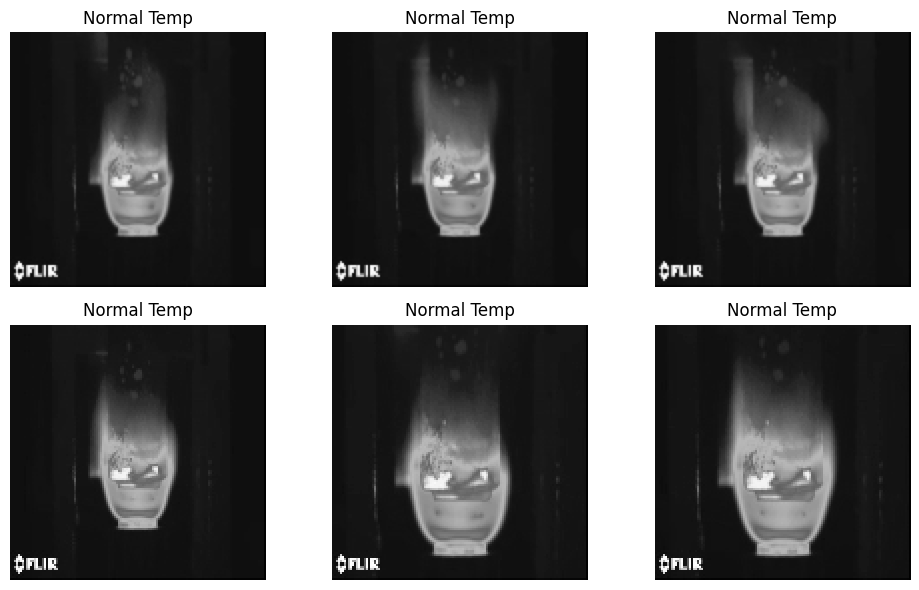

In [107]:
# Display a few samples
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title("High Temp" if train_labels[i] == 2 else "Moderate Temp" if train_labels[i] == 1 else "Normal Temp")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [108]:
print(train_images.shape)


(3120, 128, 128)


In [109]:
# Normalize images
images = np.array(train_images)
images = images / 255.0
images = images.reshape(-1, 128, 128, 1)

# Split into training, validation, and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, train_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [110]:
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Class Distribution: {dict(zip(unique, counts))}")


Class Distribution: {0: 1500, 1: 1620}


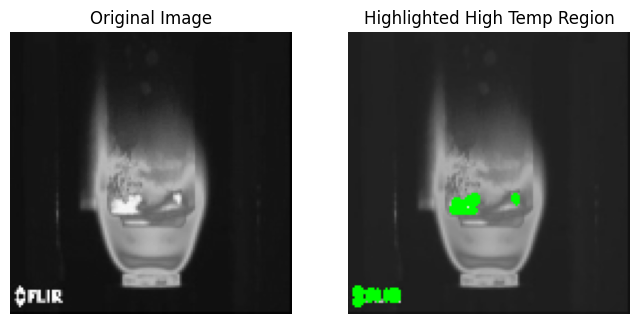

In [112]:
# Function to highlight the brightest region
'''def highlight_high_temp_region(image):
    # Threshold the image to extract the brightest region
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Draw contours on the image
    cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
    return output'''

def highlight_high_temp_region(image):
    """
    Highlights the brightest region in a grayscale image.
    Args:
        image: A 2D NumPy array representing a grayscale image.
    Returns:
        An image with the brightest region highlighted.
    """
    # Convert the image to uint8 format if not already
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Ensure pixel values are in [0, 255]
    
    # Threshold the image to extract the brightest region
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert to color for highlighting
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw contours on the image
    cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
    return output


# Apply to a sample image
sample_image = images[10].reshape(128, 128) * 255  # Reshape for visualization
highlighted = highlight_high_temp_region(sample_image.astype('uint8'))

# Display original and highlighted image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(highlighted)
plt.title("Highlighted High Temp Region")
plt.axis('off')
plt.show()


In [113]:
def extract_high_temp_features(image):
    """
    Extract features from the brightest region in the image.
    Returns features: [max_intensity, region_area, x_centroid, y_centroid]
    """
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Calculate features
        area = cv2.contourArea(largest_contour)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            x_centroid = moments["m10"] / moments["m00"]
            y_centroid = moments["m01"] / moments["m00"]
        else:
            x_centroid, y_centroid = 0, 0
        max_intensity = np.max(image)
    else:
        # Default values if no contour is found
        area, x_centroid, y_centroid, max_intensity = 0, 0, 0, np.max(image)
    
    return [max_intensity, area, x_centroid, y_centroid]

# Apply to all images
highlighted_features = np.array([extract_high_temp_features(img) for img in train_images])


In [114]:
from sklearn.preprocessing import StandardScaler

# Normalize and scale extracted features
scaler = StandardScaler()
highlighted_features_scaled = scaler.fit_transform(highlighted_features)

# Combine image data and highlighted features
X_combined = [img.flatten() for img in train_images]
X_combined = np.hstack((X_combined, highlighted_features_scaled))

# Convert to a NumPy array
X_combined = np.array(X_combined)

# Update train/test split with combined features
X_train_combined, X_temp_combined, y_train, y_temp = train_test_split(X_combined, train_labels, test_size=0.3, random_state=42, stratify=train_labels)
X_val_combined, X_test_combined, y_val, y_test = train_test_split(X_temp_combined, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [115]:
from tensorflow.keras.layers import Input, Concatenate
import tensorflow as tf
# Image Input
image_input = Input(shape=(128 * 128, ))
image_dense = Dense(256, activation='relu')(image_input)

# Highlighted Features Input
highlighted_input = Input(shape=(highlighted_features_scaled.shape[1], ))
highlighted_dense = Dense(64, activation='relu')(highlighted_input)

# Combine Both
combined = Concatenate()([image_dense, highlighted_dense])
combined_dense = Dense(128, activation='relu')(combined)
combined_output = Dense(3, activation='softmax')(combined_dense)

# Define Model
model_combined = tf.keras.Model(inputs=[image_input, highlighted_input], outputs=combined_output)

model_combined.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_combined.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16384)]              0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 256)                  4194560   ['input_5[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 64)                   320       ['input_6[0][0]']             
                                                                                            

In [116]:
history = model_combined.fit(
    [X_train_combined[:, :128*128], X_train_combined[:, 128*128:]], y_train,
    validation_data=([X_val_combined[:, :128*128], X_val_combined[:, 128*128:]], y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
69/69 [==============================] - 6s 69ms/step - loss: 92.9180 - accuracy: 0.7578 - val_loss: 89.0658 - val_accuracy: 0.4936
Epoch 2/20
69/69 [==============================] - 4s 63ms/step - loss: 15.2789 - accuracy: 0.9167 - val_loss: 5.4784 - val_accuracy: 0.9551
Epoch 3/20
69/69 [==============================] - 4s 64ms/step - loss: 1.8999 - accuracy: 0.9771 - val_loss: 0.8009 - val_accuracy: 0.9872
Epoch 4/20
69/69 [==============================] - 4s 64ms/step - loss: 2.0765 - accuracy: 0.9698 - val_loss: 3.4303 - val_accuracy: 0.9338
Epoch 5/20
69/69 [==============================] - 4s 64ms/step - loss: 21.9555 - accuracy: 0.8832 - val_loss: 8.4091 - val_accuracy: 0.9402
Epoch 6/20
69/69 [==============================] - 4s 64ms/step - loss: 2.1778 - accuracy: 0.9821 - val_loss: 0.5728 - val_accuracy: 0.9893
Epoch 7/20
69/69 [==============================] - 4s 64ms/step - loss: 4.2602 - accuracy: 0.9625 - val_loss: 0.8606 - val_accuracy: 0.9872
Epoch 8/2

In [117]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on test set
y_pred_prob = model_combined.predict([X_test_combined[:, :128*128], X_test_combined[:, 128*128:]])
y_pred = np.argmax(y_pred_prob, axis=1)


15/15 [==============================] - 0s 5ms/step


In [118]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 100.00%


In [120]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal",  "High"]))


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       225
        High       1.00      1.00      1.00       243

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468



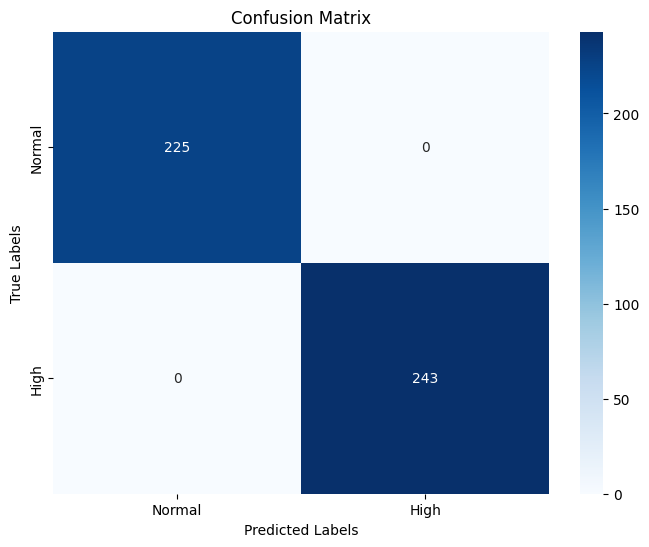

In [122]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal",  "High"], yticklabels=["Normal", "High"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


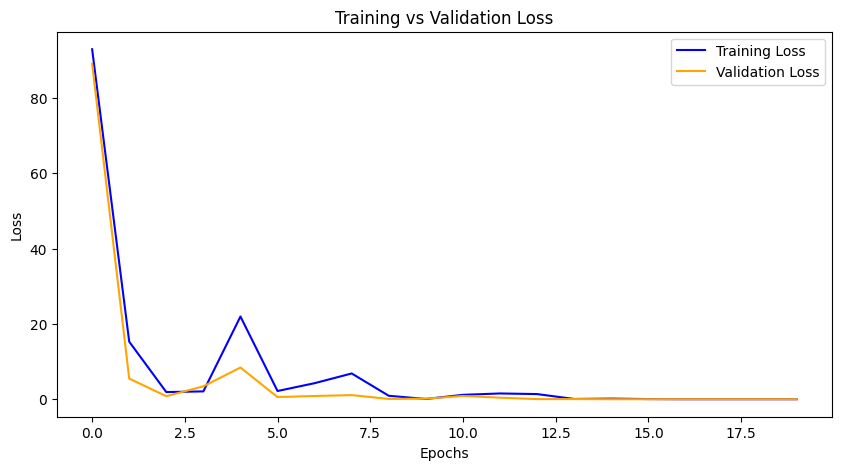

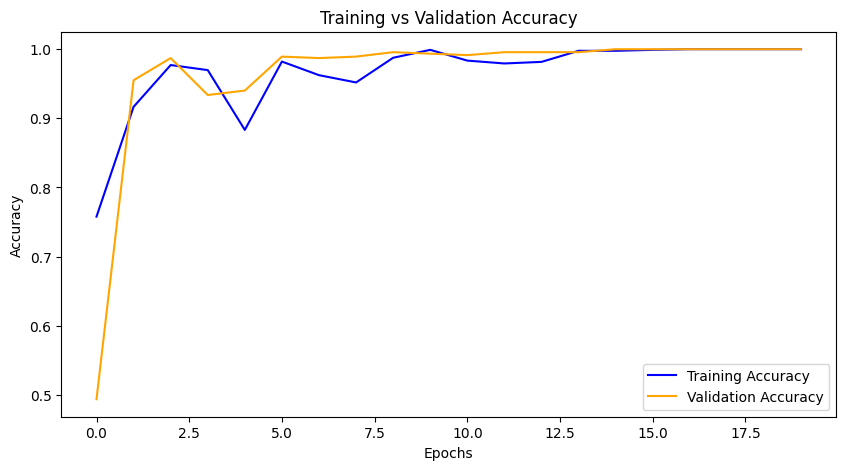

In [123]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


15/15 [==============================] - 0s 6ms/step


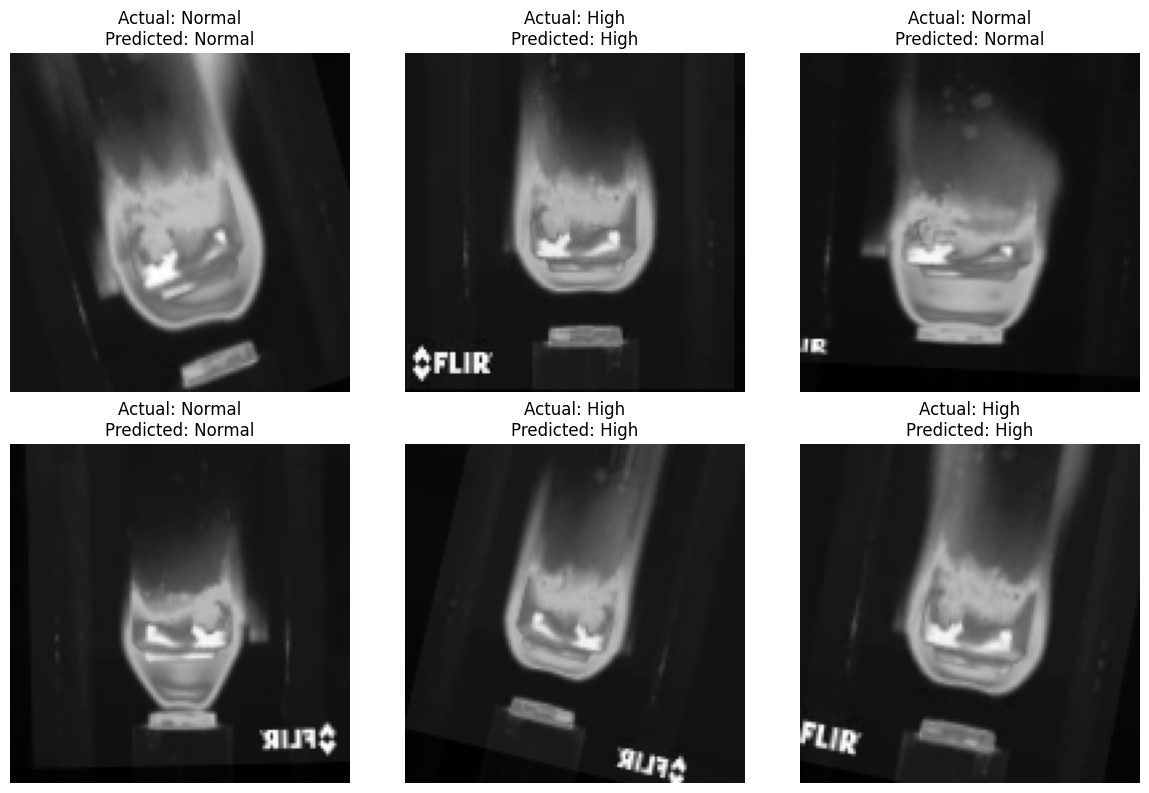

In [125]:
# Predict classes on test images
predictions = np.argmax(model_combined.predict([X_test_combined[:, :128*128], X_test_combined[:, 128*128:]]), axis=1)

# Define class labels
class_labels = ["Normal",  "High"]

# Visualize the predictions with actual labels
plt.figure(figsize=(12, 8))
for i in range(6):  # Visualizing the first 6 test images
    plt.subplot(2, 3, i + 1)
    image = X_test_combined[i, :128*128].reshape(128, 128)  # Extract image from combined input
    plt.imshow(image, cmap='gray')
    
    # Fetch actual and predicted labels
    actual_label = class_labels[y_test[i]]
    predicted_label = class_labels[predictions[i]]
    
    # Set title with both labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
